In [71]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib


In [72]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

# Read the parquet file using Dask
dft = dd.read_parquet("/home/samanehjavadinia/Co-op/Data/cfht_ngvs_lite_simbad.parquet")

# Set display options to show all columns
pd.set_option("display.max_columns", None)

# Print all column names
print(list(dft.columns))

# Define the features you want to keep
features = [
    "A_WORLD",
    "B_WORLD",
    "THETA_WORLD",
    "ERRA_WORLD",
    "ERRB_WORLD",
    "ERRTHETA_WORLD",
    "EBV",
    "U_MAG_ISO",
    "G_MAG_ISO",
    "R_MAG_ISO",
    "I_MAG_ISO",
    "Z_MAG_ISO",
    "U_MAGERR_ISO",
    "G_MAGERR_ISO",
    "R_MAGERR_ISO",
    "I_MAGERR_ISO",
    "Z_MAGERR_ISO",
    "U_MAG_APER1",
    "G_MAG_APER1",
    "R_MAG_APER1",
    "I_MAG_APER1",
    "Z_MAG_APER1",
    "U_MAG_APER3",
    "G_MAG_APER3",
    "R_MAG_APER3",
    "I_MAG_APER3",
    "Z_MAG_APER3",
    "U_MAG_APER5",
    "G_MAG_APER5",
    "R_MAG_APER5",
    "I_MAG_APER5",
    "Z_MAG_APER5",
    "U_MAGERR_APER1",
    "G_MAGERR_APER1",
    "R_MAGERR_APER1",
    "I_MAGERR_APER1",
    "Z_MAGERR_APER1",
    "U_MAGERR_APER3",
    "G_MAGERR_APER3",
    "R_MAGERR_APER3",
    "I_MAGERR_APER3",
    "Z_MAGERR_APER3",
    "U_MAGERR_APER5",
    "G_MAGERR_APER5",
    "R_MAGERR_APER5",
    "I_MAGERR_APER5",
    "Z_MAGERR_APER5",
    "U_MU_MAX",
    "G_MU_MAX",
    "R_MU_MAX",
    "I_MU_MAX",
    "Z_MU_MAX",
    "U_BACKGROUND",
    "G_BACKGROUND",
    "R_BACKGROUND",
    "I_BACKGROUND",
    "Z_BACKGROUND",
    "U_ISOAREA_IMAGE",
    "G_ISOAREA_IMAGE",
    "R_ISOAREA_IMAGE",
    "I_ISOAREA_IMAGE",
    "Z_ISOAREA_IMAGE",
    "U_FWHM_IMAGE",
    "G_FWHM_IMAGE",
    "R_FWHM_IMAGE",
    "I_FWHM_IMAGE",
    "Z_FWHM_IMAGE",
    "U_FLUX_RADIUS",
    "G_FLUX_RADIUS",
    "R_FLUX_RADIUS",
    "I_FLUX_RADIUS",
    "Z_FLUX_RADIUS",
    "U_KRON_RADIUS",
    "G_KRON_RADIUS",
    "R_KRON_RADIUS",
    "I_KRON_RADIUS",
    "Z_KRON_RADIUS",
    "U_PETRO_RADIUS",
    "G_PETRO_RADIUS",
    "R_PETRO_RADIUS",
    "I_PETRO_RADIUS",
    "Z_PETRO_RADIUS",
    "main_type",
]

# Select only the specified features
dft = dft[features]

# Drop rows where 'main_type' is NaN
dft_cleaned = dft.dropna(subset=["main_type"])

# Separate unlabeled data
unlabeled_data = dft[dft["main_type"].isna()]

['RA_in', 'DEC_in', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD', 'ERRTHETA_WORLD', 'EBV', 'U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO', 'I_MAG_ISO', 'Z_MAG_ISO', 'U_MAGERR_ISO', 'G_MAGERR_ISO', 'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO', 'U_MAG_APER1', 'G_MAG_APER1', 'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3', 'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3', 'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5', 'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1', 'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3', 'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5', 'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5', 'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX', 'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND', 'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE', 'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE',

In [73]:
# Compute the Dask dataframe to Pandas dataframe for cleaned data
dft_cleaned_pd = dft_cleaned.compute()
print("Shape of dft_cleaned:", dft_cleaned_pd.shape)

# Compute the Dask dataframe to Pandas dataframe for unlabeled data
unlabeled_data_pd = unlabeled_data.compute()
print("Shape of unlabeled_data:", unlabeled_data_pd.shape)

Shape of dft_cleaned: (48166, 83)
Shape of unlabeled_data: (24882433, 83)


In [74]:
# Sample a fraction of the unlabeled data (e.g., 10%)
sampled_unlabeled_data = unlabeled_data.sample(frac=0.1)

# Compute the sampled data to a Pandas dataframe
sampled_unlabeled_data_pd = sampled_unlabeled_data.compute()
print("Shape of sampled_unlabeled_data:", sampled_unlabeled_data_pd.shape)

# Display the sampled data
print(sampled_unlabeled_data_pd.head())

Shape of sampled_unlabeled_data: (2488240, 83)
         A_WORLD   B_WORLD  THETA_WORLD  ERRA_WORLD  ERRB_WORLD  \
262230  0.000057  0.000035     7.720000    0.000013    0.000008   
477244  0.000049  0.000036    68.980003    0.000011    0.000008   
405624  0.000040  0.000023    18.080000    0.000013    0.000007   
77703   0.000101  0.000068    37.570000    0.000009    0.000006   
222646  0.000298  0.000162     9.690000    0.000003    0.000002   

        ERRTHETA_WORLD    EBV  U_MAG_ISO  G_MAG_ISO  R_MAG_ISO  I_MAG_ISO  \
262230        7.600000  0.026  28.363800  27.465599     0.0000  26.938101   
477244       69.699997  0.024  29.386299  27.622900     0.0000  27.234200   
405624       18.299999  0.026  29.083200  28.207100     0.0000  28.325300   
77703        39.200001  0.024  27.052401  25.946501    25.7651  25.155199   
222646       11.200000  0.027  22.927900  22.346600    21.7148  21.422800   

        Z_MAG_ISO  U_MAGERR_ISO  G_MAGERR_ISO  R_MAGERR_ISO  I_MAGERR_ISO  \
262230    

In [75]:
sampled_unlabeled_data_pd.shape

(2488240, 83)

In [76]:
dft = dft_cleaned_pd.copy()

In [77]:
unlabeled_data = sampled_unlabeled_data_pd.copy()

In [78]:
# # Reading the data
# dft = Table.read('/home/samanehjavadinia/Co-op/Data/ngvs_matched.fits')


In [79]:
unlabeled_data.shape

(2488240, 83)

In [80]:
def drop_rows_with_99(df):
    """
    Drops rows from the DataFrame where any of the features have a value of 99.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with rows containing the value 99 dropped.
    """
    return  df[~(df == 99).any(axis=1)]


dft_cleaned = drop_rows_with_99(dft)
print(dft_cleaned.shape)

unlabeled_data_cleaned = drop_rows_with_99(unlabeled_data)
print(unlabeled_data_cleaned.shape)

(48131, 83)
(2460264, 83)


In [81]:
dft = dft_cleaned.copy()
unlabeled_data = unlabeled_data_cleaned.copy()

In [82]:
dft.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO',
       'I_MAG_ISO', 'Z_MAG_ISO', 'U_MAGERR_ISO', 'G_MAGERR_ISO',
       'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO', 'U_MAG_APER1',
       'G_MAG_APER1', 'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1',
       'U_MAG_APER3', 'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3',
       'Z_MAG_APER3', 'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5',
       'I_MAG_APER5', 'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1',
       'R_MAGERR_APER1', 'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3',
       'G_MAGERR_APER3', 'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3',
       'U_MAGERR_APER5', 'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5',
       'Z_MAGERR_APER5', 'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX',
       'Z_MU_MAX', 'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND',
       'I_BACKGROUND', 'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IM

<Axes: >

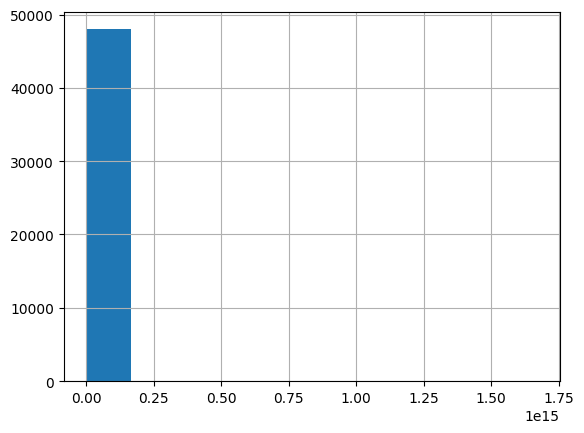

In [83]:
dft['Z_MAGERR_ISO'].hist()

In [84]:
# for column in dft.columns:
#     plt.figure()
#     dft[column].hist()
#     plt.title(f'Histogram of {column} in Cleaned Dataset')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.show()

In [85]:
# Filter to omit rows where umag is more than 30 or err is more than 0.5
filtered_dft = dft[(dft['U_MAG_ISO'] <= 30) & (dft['U_MAGERR_ISO'] <= 0.5) & 
                   (dft['G_MAGERR_ISO'] <= 0.5) & (dft['R_MAGERR_ISO']<= 0.5) & 
                   (dft['I_MAGERR_ISO']<= 0.5) & (dft['Z_MAGERR_ISO']<= 0.5)]
filtered_unlabeled_data = unlabeled_data[(unlabeled_data['U_MAG_ISO'] <= 30) 
                        & (unlabeled_data['U_MAGERR_ISO'] <= 0.5) & (unlabeled_data['G_MAGERR_ISO'] <= 0.5) &
                (unlabeled_data['R_MAGERR_ISO']<= 0.5) & (unlabeled_data['I_MAGERR_ISO']<= 0.5)& (unlabeled_data['Z_MAGERR_ISO']<= 0.5)]

print(filtered_dft.shape)
print(filtered_unlabeled_data.shape)

(47247, 83)
(1589457, 83)


In [86]:
dft = filtered_dft.copy()
unlabeled_data = filtered_unlabeled_data.copy()

In [87]:
print(dft.shape)
print(unlabeled_data.shape)


(47247, 83)
(1589457, 83)


In [88]:
unlabeled_data['main_type']

222646    None
204858    None
269159    None
271135    None
15981     None
          ... 
922       None
1378      None
18026     None
14395     None
21327     None
Name: main_type, Length: 1589457, dtype: object

In [89]:
# Function to get the value counts of columns with fewer than 5 unique values
def print_columns_with_fewer_than_5_unique_values(df):
    for column in df.columns:
        unique_values_count = df[column].nunique()
        if unique_values_count < 5:
            print(f"Value counts for column '{column}' (unique values: {unique_values_count}):")
            print(df[column].value_counts())
            print("\n")


# Assuming df is your DataFrame
print_columns_with_fewer_than_5_unique_values(dft)

In [90]:
# Assuming df is your DataFrame
print_columns_with_fewer_than_5_unique_values(unlabeled_data)

Value counts for column 'main_type' (unique values: 0):
Series([], Name: main_type, dtype: int64)




In [91]:
# Assuming df is your DataFrame
print_columns_with_fewer_than_5_unique_values(unlabeled_data)

Value counts for column 'main_type' (unique values: 0):
Series([], Name: main_type, dtype: int64)




Feature Engineering Section

In [92]:
import pandas as pd
import numpy as np

def create_feature_differences_with_errors(df, feature_groups, error_groups, proxy_feature):
    """
    Create all combinations of differences for each group of features and 
    the square root of the sum of squared errors for each combination.
    
    :param df: pandas DataFrame containing the data
    :param feature_groups: List of lists, where each sublist contains feature names to create differences from
    :param error_groups: List of lists, where each sublist contains error feature names corresponding to the feature groups
    :return: DataFrame with new difference and error features and original features dropped
    """
    for group, error_group in zip(feature_groups, error_groups):
        print(group)
        print(error_group)
        # Create combinations of differences for each group
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                diff_feature_name = f'{group[i]}_minus_{group[j]}'
                error_feature_name = f'{error_group[i]}_minus_{error_group[j]}'
                
                df[diff_feature_name] = df[group[i]] - df[group[j]]
                df[error_feature_name] = np.sqrt(df[error_group[i]]**2 + df[error_group[j]]**2)

        # Drop the original features of the current group except the proxy feature
        # print(group)
        # Create a list of features to drop (all except proxy_feature)
        features_to_drop = [feature for feature in group if feature != proxy_feature]
        df.drop(columns=features_to_drop, inplace=True)
        df.drop(columns=error_group, inplace=True)
    
    return df



# Define the proxy feature to retain
proxy_feature = 'G_MAG_ISO'

# Define the feature groups and corresponding error groups
feature_groups = [
    ['U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO',
       'I_MAG_ISO', 'Z_MAG_ISO']
]

error_groups = [
    ['U_MAGERR_ISO', 'G_MAGERR_ISO',
       'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO']
]




# Apply the function
dft = create_feature_differences_with_errors(dft, feature_groups, error_groups, proxy_feature)
unlabeled_data = create_feature_differences_with_errors(unlabeled_data, feature_groups, error_groups, proxy_feature)
print(dft.columns)
print(unlabeled_data.columns)




['U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO', 'I_MAG_ISO', 'Z_MAG_ISO']
['U_MAGERR_ISO', 'G_MAGERR_ISO', 'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO']
['U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO', 'I_MAG_ISO', 'Z_MAG_ISO']
['U_MAGERR_ISO', 'G_MAGERR_ISO', 'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO']
Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I

In [93]:
pd.set_option('display.max_columns', None)
dft.describe()

,A_WORLD,B_WORLD,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,EBV,G_MAG_ISO,U_MAG_APER1,G_MAG_APER1,R_MAG_APER1,I_MAG_APER1,Z_MAG_APER1,U_MAG_APER3,G_MAG_APER3,R_MAG_APER3,I_MAG_APER3,Z_MAG_APER3,U_MAG_APER5,G_MAG_APER5,R_MAG_APER5,I_MAG_APER5,Z_MAG_APER5,U_MAGERR_APER1,G_MAGERR_APER1,R_MAGERR_APER1,I_MAGERR_APER1,Z_MAGERR_APER1,U_MAGERR_APER3,G_MAGERR_APER3,R_MAGERR_APER3,I_MAGERR_APER3,Z_MAGERR_APER3,U_MAGERR_APER5,G_MAGERR_APER5,R_MAGERR_APER5,I_MAGERR_APER5,Z_MAGERR_APER5,U_MU_MAX,G_MU_MAX,R_MU_MAX,I_MU_MAX,Z_MU_MAX,U_BACKGROUND,G_BACKGROUND,R_BACKGROUND,I_BACKGROUND,Z_BACKGROUND,U_ISOAREA_IMAGE,G_ISOAREA_IMAGE,R_ISOAREA_IMAGE,I_ISOAREA_IMAGE,Z_ISOAREA_IMAGE,U_FWHM_IMAGE,G_FWHM_IMAGE,R_FWHM_IMAGE,I_FWHM_IMAGE,Z_FWHM_IMAGE,U_FLUX_RADIUS,G_FLUX_RADIUS,R_FLUX_RADIUS,I_FLUX_RADIUS,Z_FLUX_RADIUS,U_KRON_RADIUS,G_KRON_RADIUS,R_KRON_RADIUS,I_KRON_RADIUS,Z_KRON_RADIUS,U_PETRO_RADIUS,G_PETRO_RADIUS,R_PETRO_RADIUS,I_PETRO_RADIUS,Z_PETRO_RADIUS,U_MAG_ISO_minus_G_MAG_ISO,U_MAGERR_ISO_minus_G_MAGERR_ISO,U_MAG_ISO_minus_R_MAG_ISO,U_MAGERR_ISO_minus_R_MAGERR_ISO,U_MAG_ISO_minus_I_MAG_ISO,U_MAGERR_ISO_minus_I_MAGERR_ISO,U_MAG_ISO_minus_Z_MAG_ISO,U_MAGERR_ISO_minus_Z_MAGERR_ISO,G_MAG_ISO_minus_R_MAG_ISO,G_MAGERR_ISO_minus_R_MAGERR_ISO,G_MAG_ISO_minus_I_MAG_ISO,G_MAGERR_ISO_minus_I_MAGERR_ISO,G_MAG_ISO_minus_Z_MAG_ISO,G_MAGERR_ISO_minus_Z_MAGERR_ISO,R_MAG_ISO_minus_I_MAG_ISO,R_MAGERR_ISO_minus_I_MAGERR_ISO,R_MAG_ISO_minus_Z_MAG_ISO,R_MAGERR_ISO_minus_Z_MAGERR_ISO,I_MAG_ISO_minus_Z_MAG_ISO,I_MAGERR_ISO_minus_Z_MAGERR_ISO
count,47247.000000,47247.000000,47247.000000,4.724700e+04,4.724700e+04,47247.000000,47247.000000,47247.000000,47196.000000,47206.000000,47233.000000,47202.000000,47193.000000,47200.000000,47206.000000,47230.000000,47203.000000,47202.000000,47202.000000,47205.000000,47228.000000,47204.000000,47193.000000,47196.000000,47206.000000,47233.000000,47202.000000,47193.000000,47200.000000,47206.000000,47230.000000,47203.000000,47202.000000,47202.000000,47205.000000,47228.000000,47204.000000,47193.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47147.000000,47118.000000,47206.000000,47112.000000,47103.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.00000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000,47247.000000
mean,0.000256,0.000182,0.349472,1.782930e-06,1.321407e-06,-2.796641,0.027649,21.078196,24.661682,23.355339,5.722532,21.892822,21.966505,23.730925,22.447901,5.507829,21.077623,21.072428,23.227350,21.967871,5.400428,20.678164,20.601479,0.055246,0.013827,0.004714,0.013073,0.026990,0.036242,0.009895,0.003438,0.009870,0.020359,0.031992,0.008939,0.003262,0.009844,0.018210,22.792587,21.566944,5.281067,19.972626,20.122568,3.479562,9.617733,7.999047,23.655313,33.545732,227.768935,456.808099,76.084142,393.086135,322.111585,10.213305,8.711439,1.710753,7.384750,8.506971,4.413880,4.210652,0.853670,3.740961,3.284908,3.605151,3.611583,0.898646,3.611228,3.600110,4.780697,4.816384,1.180032,4.817832,4.78894,1.218574,0.034175,17.036423,0.033440,2.348882,0.035554,2.538795,0.040769,15.817849,0.010563,1.130308,0.014163,1.320221,0.021645,-14.687541,0.011731,-14.497628,0.019763,0.189913,0.021725
std,0.000220,0.000104,59.723671,1.784185e-06,1.270811e-06,56.589367,0.007134,2.183513,2.105349,1.892449,10.020776,1.761651,1.818131,2.085145,1.897086,9.649429,1.775337,1.822875,2.071717,1.905409,9.464609,1.797478,1.835799,0.502260,0.023401,0.023572,0.047457,0.107902,0.094118,0.016993,0.014919,0.028322,0.238757,0.096781,0.016025,0.015069,0.038550,0.060683,1.992587,

In [94]:
dft['main_type'].value_counts()

Galaxy             14538
GinCl               6344
GlCl                5025
Star                4448
GlCl?_Candidate     4160
                   ...  
Nova_Candidate         1
Eruptive*              1
BLLac_Candidate        1
CV*_Candidate          1
brownD*                1
Name: main_type, Length: 93, dtype: int64

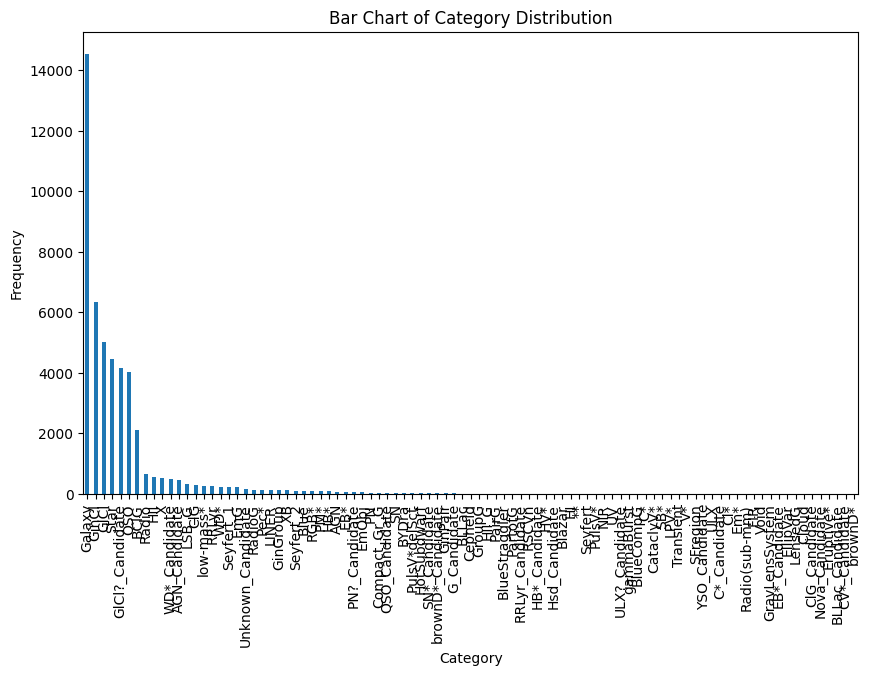

In [95]:
# Create and display the pie chart of the new column
category_counts = dft['main_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

The number of different categories in the new grouped column: 8


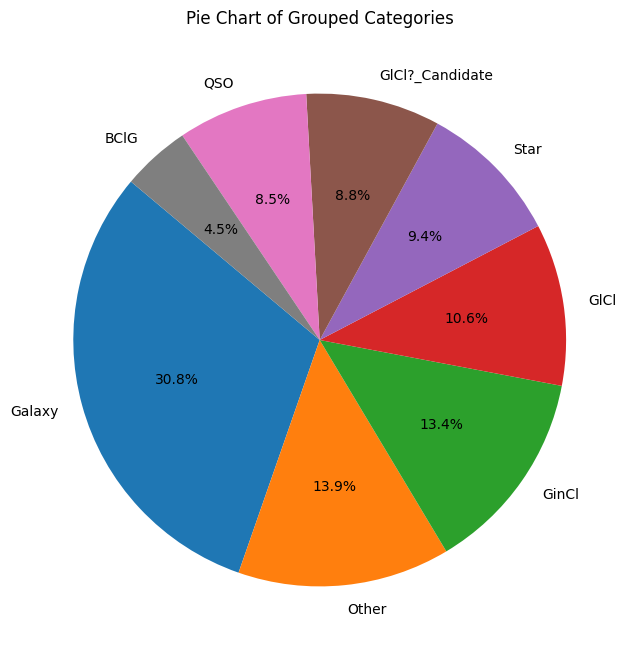

In [96]:
# Count the occurrences of each category
category_counts = dft['main_type'].value_counts()

# Specify the categorical column
category_column = 'main_type'

# Define the threshold for rare categories
threshold = 1000  # Categories with counts less than or equal to this will be grouped into "Other"

# Count the occurrences of each category
category_counts = dft[category_column].value_counts()

# Identify the rare categories
rare_categories = category_counts[category_counts <= threshold].index

# Create a new column with grouped categories
dft['grouped_category'] = dft[category_column].apply(lambda x: 'Other' if x in rare_categories else x)

# Print the number of different categories in the new column
num_categories = dft['grouped_category'].nunique()
print(f'The number of different categories in the new grouped column: {num_categories}')



# Count the occurrences of each category
category_counts = dft['grouped_category'].value_counts()


# Create and display the pie chart of the new column
category_counts = dft['grouped_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Grouped Categories')
plt.show()

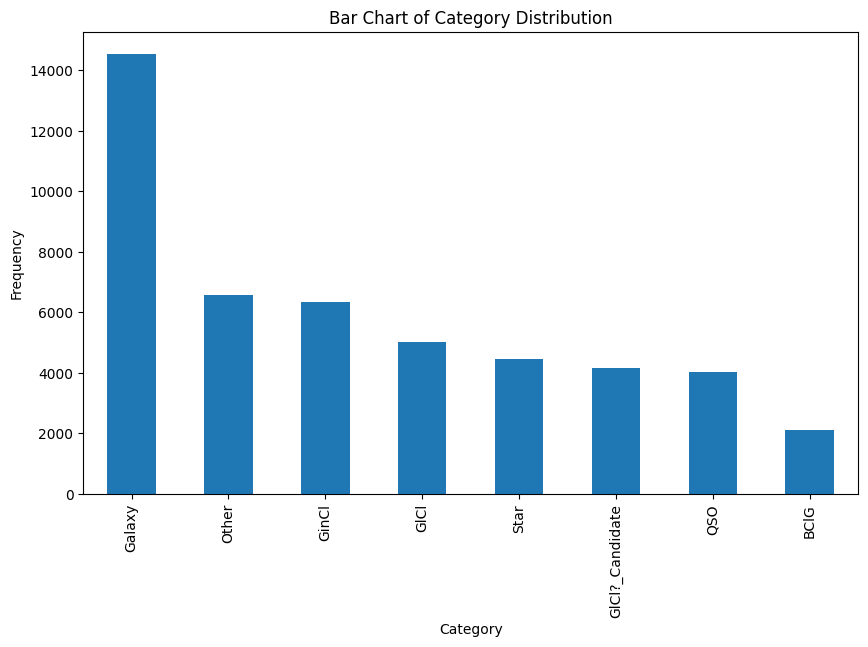

In [97]:
# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [98]:
dft['grouped_category'].value_counts()

Galaxy             14538
Other               6582
GinCl               6344
GlCl                5025
Star                4448
GlCl?_Candidate     4160
QSO                 4036
BClG                2114
Name: grouped_category, dtype: int64

In [99]:
dft.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

In [100]:
dft = dft.drop(columns='main_type')

In [101]:
# Get the unique types in the 'grouped_category' column
unique_types = dft['grouped_category'].apply(type).unique()
print("Different types in 'grouped_category' column:", unique_types)

Different types in 'grouped_category' column: [<class 'str'>]


In [102]:
# Ensure all values in 'grouped_category' are strings
dft['grouped_category'] = dft['grouped_category'].astype(str)

In [103]:
df = dft.copy()

In [104]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoder = LabelEncoder()
df['main_type_encoded'] = label_encoder.fit_transform(df['grouped_category'])

# Save the encoder to disk
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [105]:
df.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

/tmp/ipykernel_174995/3921513225.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


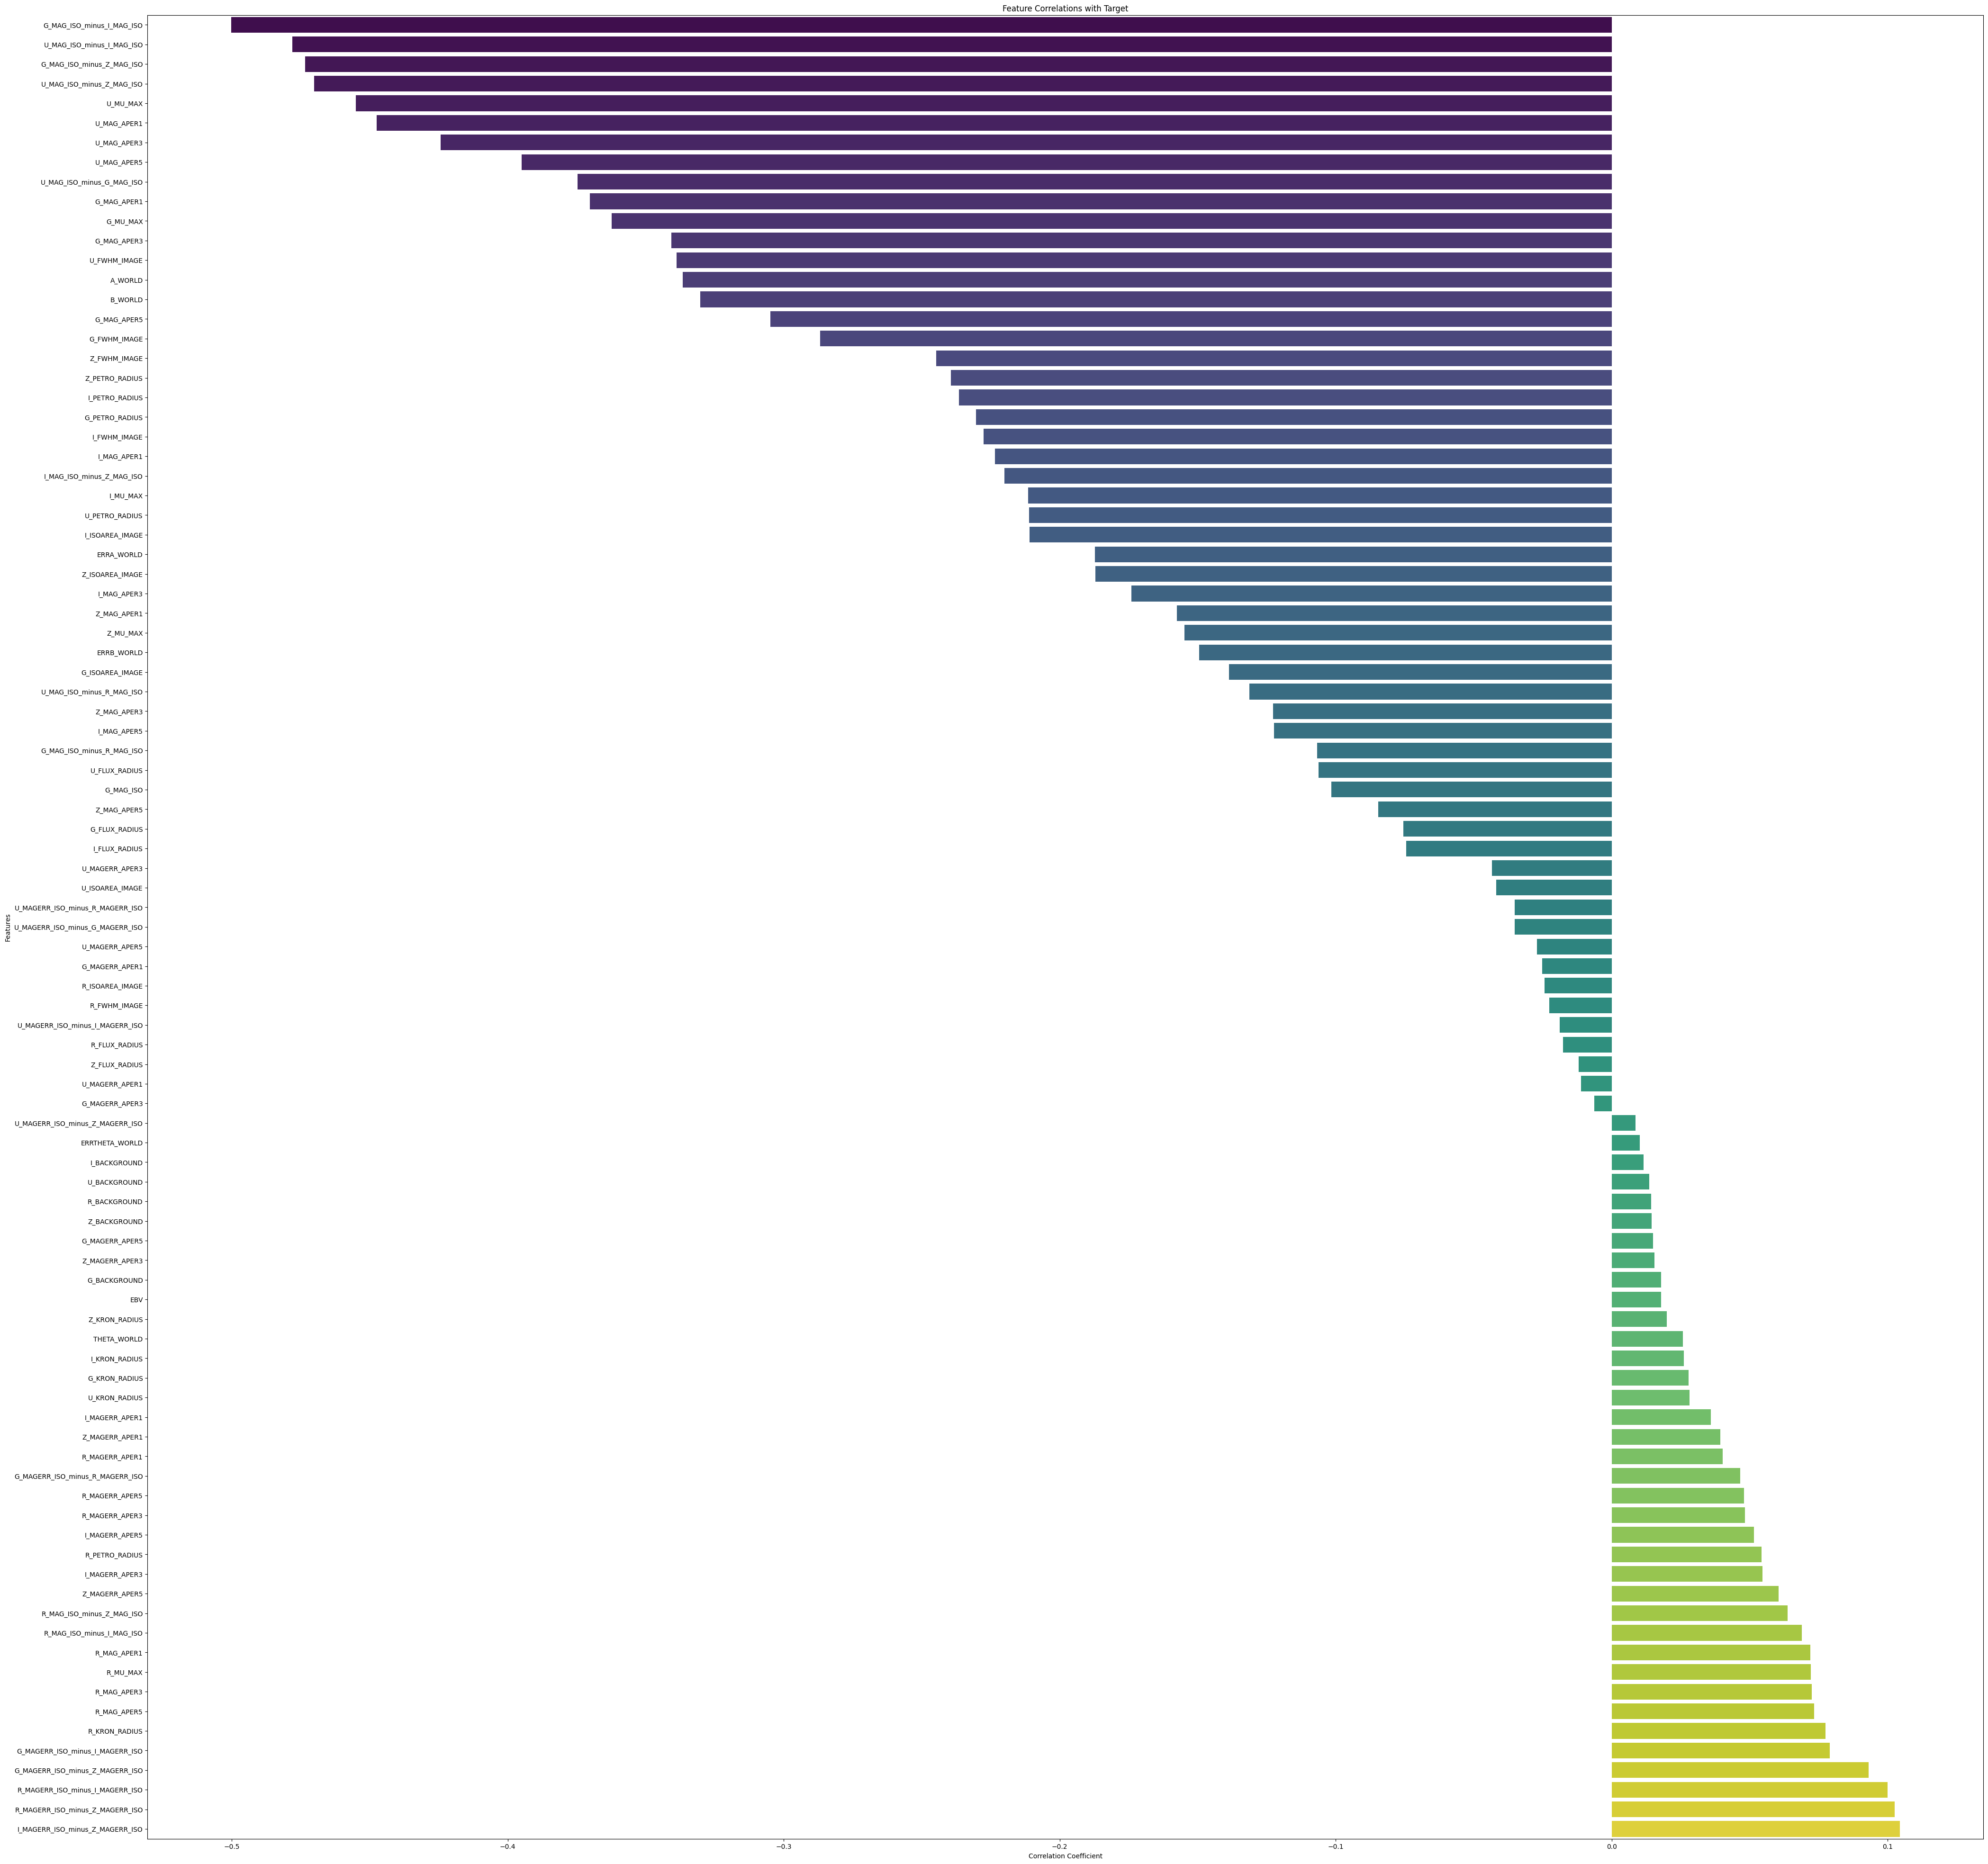

In [106]:
 # Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlations of the features with the target
correlation_with_target = correlation_matrix['main_type_encoded'].drop('main_type_encoded')


# Sort correlations
sorted_correlations = correlation_with_target.sort_values()

# Plot the correlations
plt.figure(figsize=(50, 50))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette="viridis")
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [107]:
# from pandas.plotting import scatter_matrix

# attributes = [ 'iC', 'iCerr', 'ebv', 'background_g', 'ug0', 'gi0', 'iz0', 'p_star',
#        'p_gc', 'p_galx', 'umag_minus_gmag', 'umag_minus_rmag',
#        'umag_minus_imag', 'umag_minus_zmag', 'gmag_minus_rmag',
#        'gmag_minus_imag', 'gmag_minus_zmag', 'rmag_minus_imag',
#        'rmag_minus_zmag', 'imag_minus_zmag', 'uerr_minus_gerr',
#        'uerr_minus_rerr', 'uerr_minus_ierr', 'uerr_minus_zerr',
#        'gerr_minus_rerr', 'gerr_minus_ierr', 'gerr_minus_zerr',
#        'rerr_minus_ierr', 'rerr_minus_zerr', 'ierr_minus_zerr',
#        'grouped_category', 'main_type_encoded']
# scatter_matrix(df[attributes], figsize=(40, 40))
# plt.show()

In [108]:
df = df.drop(columns=[ 'grouped_category'])

In [109]:
unlabeled_data.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

In [110]:
unlabeled_data['main_type'].value_counts()

Series([], Name: main_type, dtype: int64)

In [111]:
unlabeled_data = unlabeled_data.drop(columns=[ 'main_type'])

In [112]:
unlabeled_data.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

In [113]:
import os

# Verify the directory structure
print(os.listdir('/home/samanehjavadinia/Co-op/Data/'))

['ngvs_matched.fits', 'cfht_ngvs_lite_simbad.parquet', 'CFHT_modified_dataset.csv', 'CFHT_unlabeled_data.csv']


In [114]:
# Save the train and test datasets to CSV files
df.to_csv('/home/samanehjavadinia/Co-op/Data/CFHT_modified_dataset.csv', index=False)
unlabeled_data.to_csv('/home/samanehjavadinia/Co-op/Data/CFHT_unlabeled_data.csv', index=False)

#############LOading
###########
#######
#########
#########


In [173]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib

In [174]:
# If you want to load the data later, you can use the following code
df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/CFHT_modified_dataset.csv')
unlabeled_data = pd.read_csv('/home/samanehjavadinia/Co-op/Data/CFHT_unlabeled_data.csv')
# Load the encoder from disk
label_encoder = joblib.load('label_encoder.pkl')

In [ ]:
# # If you want to load the data later, you can use the following code
# df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv')
# unlabeled_data = pd.read_csv('/home/samanehjavadinia/Co-op/Data/unlabeled_data.csv')
# # Load the encoder from disk
# label_encoder = joblib.load('label_encoder.pkl')


In [175]:
df.shape

(47247, 94)

In [176]:
# Decode the labels in the labeled dataset
decoded_labels = label_encoder.inverse_transform(df['main_type_encoded'])



In [177]:
np.unique(decoded_labels)

array(['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other',
       'QSO', 'Star'], dtype=object)

In [178]:
# Assuming 'arr' is your numpy array
arr_series = pd.Series(decoded_labels)
value_counts = arr_series.value_counts()
print(value_counts)

Galaxy             14538
Other               6582
GinCl               6344
GlCl                5025
Star                4448
GlCl?_Candidate     4160
QSO                 4036
BClG                2114
dtype: int64


In [179]:
df.head()

,A_WORLD,B_WORLD,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,EBV,G_MAG_ISO,U_MAG_APER1,G_MAG_APER1,R_MAG_APER1,I_MAG_APER1,Z_MAG_APER1,U_MAG_APER3,G_MAG_APER3,R_MAG_APER3,I_MAG_APER3,Z_MAG_APER3,U_MAG_APER5,G_MAG_APER5,R_MAG_APER5,I_MAG_APER5,Z_MAG_APER5,U_MAGERR_APER1,G_MAGERR_APER1,R_MAGERR_APER1,I_MAGERR_APER1,Z_MAGERR_APER1,U_MAGERR_APER3,G_MAGERR_APER3,R_MAGERR_APER3,I_MAGERR_APER3,Z_MAGERR_APER3,U_MAGERR_APER5,G_MAGERR_APER5,R_MAGERR_APER5,I_MAGERR_APER5,Z_MAGERR_APER5,U_MU_MAX,G_MU_MAX,R_MU_MAX,I_MU_MAX,Z_MU_MAX,U_BACKGROUND,G_BACKGROUND,R_BACKGROUND,I_BACKGROUND,Z_BACKGROUND,U_ISOAREA_IMAGE,G_ISOAREA_IMAGE,R_ISOAREA_IMAGE,I_ISOAREA_IMAGE,Z_ISOAREA_IMAGE,U_FWHM_IMAGE,G_FWHM_IMAGE,R_FWHM_IMAGE,I_FWHM_IMAGE,Z_FWHM_IMAGE,U_FLUX_RADIUS,G_FLUX_RADIUS,R_FLUX_RADIUS,I_FLUX_RADIUS,Z_FLUX_RADIUS,U_KRON_RADIUS,G_KRON_RADIUS,R_KRON_RADIUS,I_KRON_RADIUS,Z_KRON_RADIUS,U_PETRO_RADIUS,G_PETRO_RADIUS,R_PETRO_RADIUS,I_PETRO_RADIUS,Z_PETRO_RADIUS,U_MAG_ISO_minus_G_MAG_ISO,U_MAGERR_ISO_minus_G_MAGERR_ISO,U_MAG_ISO_minus_R_MAG_ISO,U_MAGERR_ISO_minus_R_MAGERR_ISO,U_MAG_ISO_minus_I_MAG_ISO,U_MAGERR_ISO_minus_I_MAGERR_ISO,U_MAG_ISO_minus_Z_MAG_ISO,U_MAGERR_ISO_minus_Z_MAGERR_ISO,G_MAG_ISO_minus_R_MAG_ISO,G_MAGERR_ISO_minus_R_MAGERR_ISO,G_MAG_ISO_minus_I_MAG_ISO,G_MAGERR_ISO_minus_I_MAGERR_ISO,G_MAG_ISO_minus_Z_MAG_ISO,G_MAGERR_ISO_minus_Z_MAGERR_ISO,R_MAG_ISO_minus_I_MAG_ISO,R_MAGERR_ISO_minus_I_MAGERR_ISO,R_MAG_ISO_minus_Z_MAG_ISO,R_MAGERR_ISO_minus_Z_MAGERR_ISO,I_MAG_ISO_minus_Z_MAG_ISO,I_MAGERR_ISO_minus_Z_MAGERR_ISO,main_type_encoded
0,0.000069,0.000064,-85.97,2.436208e-06,2.292044e-06,-89.7,0.027,24.4150,27.5795,25.3589,24.6890,24.2653,24.2376,26.6330,24.6395,24.0363,23.5861,23.5225,26.1176,24.3491,23.7885,23.3248,23.2243,0.2007,0.0302,0.0305,0.0321,0.0565,0.1396,0.0256,0.0276,0.0282,0.0485,0.1216,0.0272,0.0305,0.0309,0.0515,25.3313,23.5675,22.8086,22.3794,22.4555,13.426110,50.208010,95.658700,131.825600,180.917900,0.0,16.0,13.0,13.0,6.0,0.00,3.84,3.36,3.48,4.27,3.105,2.221,2.066,2.202,4.680,3.5,3.5,3.5,3.5,3.5,5.28,5.28,5.28,5.28,5.28,1.899500,0.131633,2.464602,0.132252,2.908602,0.132428,2.991001,0.138444,0.565102,0.038525,1.009102,0.039125,1.091501,0.056218,0.444000,0.041158,0.526400,0.057651,0.082399,0.058054,3
1,0.000115,0.000112,-58.92,6.379154e-07,5.936365e-07,-31.4,0.029,21.4813,24.6167,22.7154,22.1148,21.7474,21.8574,23.7701,22.0113,21.4181,21.0743,21.0877,23.3437,21.7265,21.1479,20.8141,20.7509,0.0137,0.0035,0.0036,0.0036,0.0065,0.0100,0.0027,0.0028,0.0029,0.0051,0.0090,0.0026,0.0028,0.0029,0.0050,22.9154,20.9516,20.2963,19.9311,20.1238,0.878222,2.390778,4.150166,5.863898,8.051213,62.0,89.0,86.0,77.0,63.0,4.87,3.45,3.39,3.22,3.88,2.720,2.058,2.030,1.995,2.336,3.5,3.5,3.5,3.5,3.5,3.96,3.96,3.96,3.96,3.96,1.424099,0.012472,2.000900,0.012747,2.334099,0.012816,2.490999,0.014204,0.576801,0.005482,0.910000,0.005640,1.066900,0.008326,0.333199,0.006224,0.490099,0.008732,0.156900,0.008832,3
2,0.000097,0.000092,87.76,8.282170e-07,7.726438e-07,-88.7,0.026,22.5600,25.5915,23.6513,23.0480,22.6800,22.8058,24.7090,22.9662,22.4126,22.0719,22.0885,24.3048,22.7019,22.1782,21.8572,21.8081,0.0281,0.0060,0.0064,0.0072,0.0144,0.0204,0.0049,0.0056,0.0064,0.0121,0.0192,0.0050,0.0060,0.0069,0.0128,23.8748,21.8459,21.2239,20.8015,21.0134,2.300401,7.189379,14.220090,18.898070,30.327980,29.0,54.0,44.0,37.0,29.0,5.10,3.33,3.04,2.91,3.57,2.446,1.902,1.748,1.666,1.900,3.5,3.5,3.5,3.5,3.5,4.62,4.62,4.62,4.62,4.62,1.496500,0.023119,1.986300,0.023625,2.288700,0.024123,2.397200,0.027741,0.489799,0.009902,0.792200,0.011039,0.900700,0.017591,0.302401,0.012062,0.410900,0.018251,0.108500,0.018892,3
3,0.000113,0.000095,72.98,1.755852e-06,1.296500e-06,67.7,0.027,23.0577,26.3277,24.2518,23.5777,23.1581,23.2102,25.5112,23.5564,22.8874,22.5069,22.4709,25.1229,23.2748,22.6007,22.2617,22.1563,0.0599,0.0104,0.0105,0.0111,0.0211,0.0465,0.0087,0.0090,0.0098,0.0175,0.0451,0.0090,0.0094,0.0106,0.0182,24.5914,22.4037,21.7470,21.2060,21.3885,6.024473,21.476960,41.014430,55.53

In [ ]:
# df_angdist = df.copy()
# df = df.drop(columns = 'angDist')

In [180]:
df.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

In [181]:
df['main_type_encoded'].value_counts()

1    14538
5     6582
2     6344
3     5025
7     4448
4     4160
6     4036
0     2114
Name: main_type_encoded, dtype: int64

In [182]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)

# Further split the training data into a training set and a calibration set
train_df, calib_df = train_test_split(train_df, test_size=0.2, stratify=train_df['main_type_encoded'], random_state=42)

# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']
X_calib = calib_df.drop(columns=['main_type_encoded'])
y_calib = calib_df['main_type_encoded']

# # Save the original indices for reference
# train_indices = train_df['original_index']
# test_indices = test_df['original_index']
# calib_indices = calib_df['original_index']

In [183]:
y_test.value_counts()

1    2908
5    1316
2    1269
3    1005
7     890
4     832
6     807
0     423
Name: main_type_encoded, dtype: int64

In [184]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numeric_columns(train_df, test_df, calib_df):
    # Identify non-numeric and numeric columns
    non_numeric_columns = train_df.select_dtypes(include=['object']).columns
    numeric_columns = train_df.select_dtypes(exclude=['object']).columns

    # Separate non-numeric and numeric columns
    train_non_numeric = train_df[non_numeric_columns]
    train_numeric = train_df[numeric_columns]

    test_non_numeric = test_df[non_numeric_columns]
    test_numeric = test_df[numeric_columns]
    
    calib_non_numeric = calib_df[non_numeric_columns]
    calib_numeric = calib_df[numeric_columns]

    # Handle missing values in numeric columns
    train_numeric = train_numeric.dropna()
    test_numeric = test_numeric.dropna()
    calib_numeric = calib_numeric.dropna()

    # Scale the numeric columns
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled = scaler.transform(test_numeric)
    calib_numeric_scaled = scaler.transform(calib_numeric)
    
    # Convert the scaled array back to DataFrames
    train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_columns)
    test_numeric_scaled = pd.DataFrame(test_numeric_scaled, columns=numeric_columns)
    calib_numeric_scaled = pd.DataFrame(calib_numeric_scaled, columns=numeric_columns)
    
    # Combine the scaled numeric columns with the non-numeric columns
    train_scaled = pd.concat([train_numeric_scaled, train_non_numeric.reset_index(drop=True)], axis=1)
    test_scaled = pd.concat([test_numeric_scaled, test_non_numeric.reset_index(drop=True)], axis=1)
    calib_scaled = pd.concat([calib_numeric_scaled, calib_non_numeric.reset_index(drop=True)], axis=1)

    return train_scaled, test_scaled, calib_scaled

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
X_train_scaled, X_test_scaled, X_calib_scaled = scale_numeric_columns(X_train, X_test, X_calib )
# print("Scaled train data:", X_train_scaled.head())
# print("Scaled test data:", X_test_scaled.head())

X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()
X_calib = X_calib_scaled.copy()

In [185]:
X_train.head()

,A_WORLD,B_WORLD,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,EBV,G_MAG_ISO,U_MAG_APER1,G_MAG_APER1,R_MAG_APER1,I_MAG_APER1,Z_MAG_APER1,U_MAG_APER3,G_MAG_APER3,R_MAG_APER3,I_MAG_APER3,Z_MAG_APER3,U_MAG_APER5,G_MAG_APER5,R_MAG_APER5,I_MAG_APER5,Z_MAG_APER5,U_MAGERR_APER1,G_MAGERR_APER1,R_MAGERR_APER1,I_MAGERR_APER1,Z_MAGERR_APER1,U_MAGERR_APER3,G_MAGERR_APER3,R_MAGERR_APER3,I_MAGERR_APER3,Z_MAGERR_APER3,U_MAGERR_APER5,G_MAGERR_APER5,R_MAGERR_APER5,I_MAGERR_APER5,Z_MAGERR_APER5,U_MU_MAX,G_MU_MAX,R_MU_MAX,I_MU_MAX,Z_MU_MAX,U_BACKGROUND,G_BACKGROUND,R_BACKGROUND,I_BACKGROUND,Z_BACKGROUND,U_ISOAREA_IMAGE,G_ISOAREA_IMAGE,R_ISOAREA_IMAGE,I_ISOAREA_IMAGE,Z_ISOAREA_IMAGE,U_FWHM_IMAGE,G_FWHM_IMAGE,R_FWHM_IMAGE,I_FWHM_IMAGE,Z_FWHM_IMAGE,U_FLUX_RADIUS,G_FLUX_RADIUS,R_FLUX_RADIUS,I_FLUX_RADIUS,Z_FLUX_RADIUS,U_KRON_RADIUS,G_KRON_RADIUS,R_KRON_RADIUS,I_KRON_RADIUS,Z_KRON_RADIUS,U_PETRO_RADIUS,G_PETRO_RADIUS,R_PETRO_RADIUS,I_PETRO_RADIUS,Z_PETRO_RADIUS,U_MAG_ISO_minus_G_MAG_ISO,U_MAGERR_ISO_minus_G_MAGERR_ISO,U_MAG_ISO_minus_R_MAG_ISO,U_MAGERR_ISO_minus_R_MAGERR_ISO,U_MAG_ISO_minus_I_MAG_ISO,U_MAGERR_ISO_minus_I_MAGERR_ISO,U_MAG_ISO_minus_Z_MAG_ISO,U_MAGERR_ISO_minus_Z_MAGERR_ISO,G_MAG_ISO_minus_R_MAG_ISO,G_MAGERR_ISO_minus_R_MAGERR_ISO,G_MAG_ISO_minus_I_MAG_ISO,G_MAGERR_ISO_minus_I_MAGERR_ISO,G_MAG_ISO_minus_Z_MAG_ISO,G_MAGERR_ISO_minus_Z_MAGERR_ISO,R_MAG_ISO_minus_I_MAG_ISO,R_MAGERR_ISO_minus_I_MAGERR_ISO,R_MAG_ISO_minus_Z_MAG_ISO,R_MAGERR_ISO_minus_Z_MAGERR_ISO,I_MAG_ISO_minus_Z_MAG_ISO,I_MAGERR_ISO_minus_Z_MAGERR_ISO
0,0.024732,0.089315,0.872500,0.097828,0.182565,0.911111,0.206897,0.592900,0.625764,0.609478,0.000000,0.351490,0.385061,0.724687,0.612589,0.000000,0.408190,0.409723,0.602325,0.614511,0.000000,0.404350,0.405872,0.007949,0.062838,0.000000,0.002238,0.003357,0.048399,0.057751,0.000000,0.005145,0.003184,0.005078,0.051891,0.000000,0.004504,0.002506,0.842709,0.644481,0.000000,0.430432,0.484985,0.000246,0.000729,0.001215,0.000660,0.002322,0.000058,0.002914,0.000000,0.006489,0.006684,0.046568,0.035432,0.056683,0.032343,0.029948,0.561046,0.129303,0.755272,0.155559,0.990560,0.440299,0.440299,0.000000,0.440299,0.440299,0.687500,0.687500,0.000000,0.687500,0.687500,0.649454,0.211734,0.859477,0.185883,0.705980,0.203472,0.673050,0.165790,0.804193,0.024832,0.557079,0.027352,0.603573,0.031934,0.234965,0.008679,0.234530,0.014623,0.748031,0.015494
1,0.033972,0.117682,0.746389,0.090270,0.160955,0.722778,0.103448,0.534110,0.589514,0.542799,0.759361,0.302016,0.356737,0.678235,0.548060,0.785500,0.353821,0.374880,0.561929,0.551456,0.772620,0.351734,0.368130,0.003399,0.022297,0.002110,0.000971,0.001375,0.019257,0.020408,0.006051,0.002315,0.001194,0.001944,0.018030,0.004677,0.001896,0.000914,0.820859,0.568123,0.795913,0.364780,0.458698,0.000301,0.001183,0.003239,0.001076,0.002681,0.000991,0.005693,0.023392,0.011949,0.014315,0.047814,0.036145,0.085756,0.034980,0.036124,0.561242,0.129394,0.778071,0.155667,0.990580,0.373134,0.373134,0.380849,0.373134,0.373134,0.500000,0.500000,0.500000,0.500000,0.500000,0.633298,0.087236,0.164912,0.076884,0.685476,0.083912,0.654595,0.068322,0.105158,0.011653,0.547913,0.011047,0.594972,0.012478,0.925694,0.007652,0.898080,0.007851,0.743171,0.006351
2,0.154954,0.255115,0.150389,0.019879,0.017325,0.141667,0.068966,0.180926,0.310870,0.167130,0.681773,0.125389,0.158291,0.349873,0.157252,0.688826,0.129000,0.156007,0.282047,0.152878,0.664457,0.111453,0.145685,0.000178,0.002027,0.000482,0.000253,0.000224,0.000871,0.001303,0.001121,0.000386,0.000159,0.000072,0.001319,0.000779,0.000356,0.000102,0.379071,0.083191,0.676419,0.044886,0.130200,0.001350,0.017169,0.038025,0.016249,0.014220,0.125073,0.154964,0.417182,0.181741,0.214466,0.076731,0.074594,0.130798,0.092143,0.072975,0.562950,0.130528,0.802583,0.156805,0.990698,0.373134,0.373134,0.380849,0.373134,0.373134,0.331439,0.331439,0.331439,0.331439,0.331439,0.563655,0.001867,0.115637,0.001719,0.490221,0.001805,0.497948,0.001512,0.074557,0.000596,0.341182,0.000542,0.461871,0.000699,0.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'df' is your original dataframe and 'main_type_encoded' is the column with encoded labels
# Convert the original encoded labels back to their original class labels
df['main_type_original'] = label_encoder.inverse_transform(df['main_type_encoded'])

print("Original Data Labels:", df['main_type_original'].unique())



# Define your specific classes
classes = np.array(['GlCl', 'Star'و'Galaxy',  'GlCl?_Candidate'و 'GinCl',  'Other' , 'QSO', 'BClG'])
colors = sns.color_palette('hsv', len(classes))

# Plot the results for the original dataframe with original labels
plt.figure(figsize=(10, 6))

# Highlight different original classes with different colors
for class_label, color in zip(classes, colors):
    class_indices = df['main_type_original'] == class_label
    plt.scatter(
        df['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
        df['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
        c=[color],  # Color for these points
        s=20,
        label=f'Original {class_label}'  # Label for legend
    )

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Original Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

df = df.drop(columns='main_type_original')

########### Training on XGBoost
############
############
###########
###########

In [142]:
X_train.shape

(30237, 93)

/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy: 0.31
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       423
           1       0.31      1.00      0.47      2908
           2       0.00      0.00      0.00      1269
           3       0.00      0.00      0.00      1005
           4       0.00      0.00      0.00       832
           5       0.17      0.00      0.00      1316
           6       0.00      0.00      0.00       807
           7       0.00      0.00      0.00       890

    accuracy                           0.31      9450
   macro avg       0.06      0.12      0.06      9450
weighted avg       0.12      0.31      0.15      9450



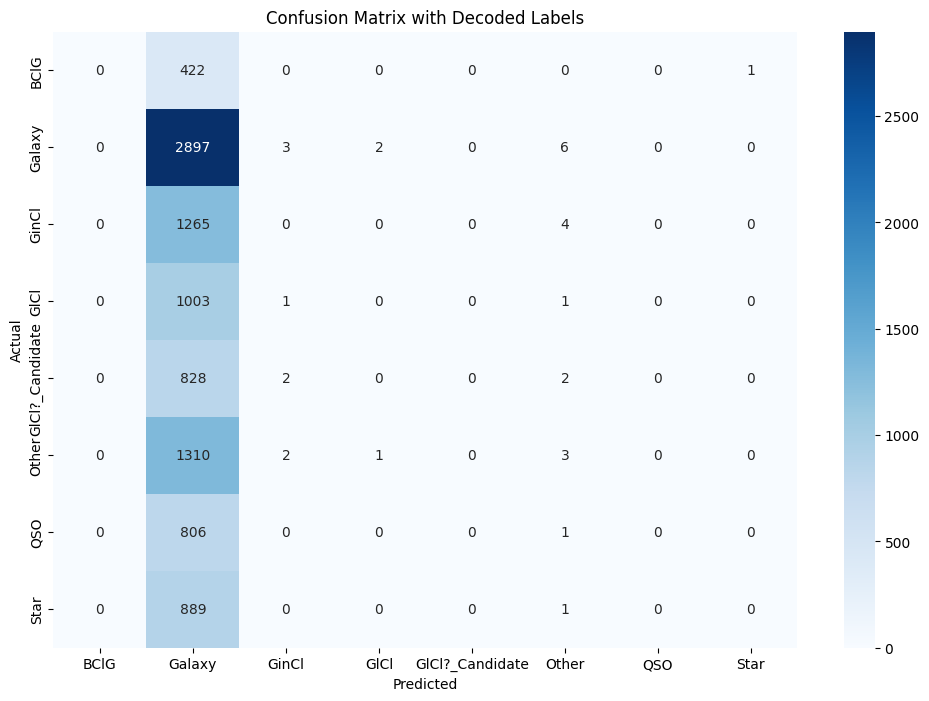

Model saved to best_xgboost_model.pkl


In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb


# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_classifier = grid_search.best_estimator_

# Predict the test set results
y_pred = best_xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(report)

# Decode the labels
# Assuming you have label encoder and decoded labels from your previous steps
decoded_labels = label_encoder.inverse_transform(np.unique(y_test))

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'best_xgboost_model.pkl'
joblib.dump(best_xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [161]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import xgboost as xgb
# import numpy as np
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score



# y_train_encoded = y_train
# y_test_encoded = y_test


# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# # Train the XGBoost classifier
# xgb_classifier.fit(X_train, y_train_encoded)

# # Apply conformal prediction using the calibration set
# mapie_clf = MapieClassifier(estimator=xgb_classifier, method="score", cv="prefit")
# mapie_clf.fit(X_train, y_train_encoded)

# # Try different alpha levels to find the best coverage
# alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# best_alpha = 0
# best_coverage = 0

# for alpha in alphas:
#     y_pred, y_pis = mapie_clf.predict(X_test, alpha=alpha)
#     y_pis_transformed = np.array([set(np.where(y_pis[i])[0]) for i in range(len(y_pis))])
#     y_pis_boolean = np.zeros((len(y_test_encoded), len(np.unique(y_test_encoded))), dtype=bool)
#     for i in range(len(y_test_encoded)):
#         y_pis_boolean[i, list(y_pis_transformed[i])] = True
#     coverage = classification_coverage_score(y_test_encoded, y_pis_boolean)
#     print(f"Alpha: {alpha}, Coverage: {coverage:.2f}")
#     if coverage > best_coverage:
#         best_coverage = coverage
#         best_alpha = alpha

# print(f"Best Alpha: {best_alpha}, Best Coverage: {best_coverage:.2f}")

# # Final prediction with the best alpha
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=best_alpha)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_encoded, y_pred)
# report = classification_report(y_test_encoded, y_pred)
# conf_matrix = confusion_matrix(y_test_encoded, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print(report)

# # Decode the labels
# decoded_labels = label_encoder.inverse_transform(np.unique(y_test_encoded))

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'xgboost_model_multi_classification.pkl'
# joblib.dump(xgb_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [144]:
# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)




Label Mapping: {'BClG': 0, 'Galaxy': 1, 'GinCl': 2, 'GlCl': 3, 'GlCl?_Candidate': 4, 'Other': 5, 'QSO': 6, 'Star': 7}
['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other', 'QSO', 'Star']


In [145]:
# Assuming label_encoder is already fitted
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the key-value pairs
for original_label, encoded_value in label_mapping.items():
    print(f"{original_label}: {encoded_value}")

BClG: 0
Galaxy: 1
GinCl: 2
GlCl: 3
GlCl?_Candidate: 4
Other: 5
QSO: 6
Star: 7


In [146]:
# Make predictions on the unlabeled dataset
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)

# Initialize an array to store the final predictions
unlabeled_data_pred = np.argmax(unlabeled_data_proba, axis=1)

# Convert final predictions to original class labels
final_pred_labels = label_encoder.inverse_transform(unlabeled_data_pred)

print(final_pred_labels)

['Star' 'Star' 'Other' ... 'GlCl?_Candidate' 'Other' 'Other']


In [147]:
np.unique(final_pred_labels)

array(['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other',
       'QSO', 'Star'], dtype=object)

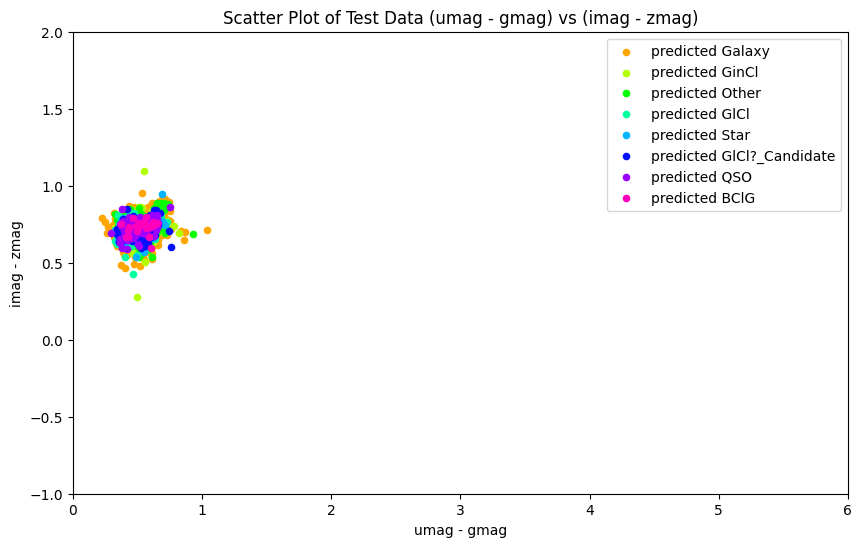

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
test_data_pred = xgb_classifier.predict(X_test)
final_pred_labels_test = label_encoder.inverse_transform(test_data_pred)


# Define your specific classes
classes = np.array(['Galaxy', 'GinCl',  'Other', 'GlCl', 'Star', 'GlCl?_Candidate', 'QSO', 'BClG'])
colors = sns.color_palette('hsv', len(classes))

# Plot the results for the test set
plt.figure(figsize=(10, 6))

# Highlight different original classes with different colors
for class_label, color in zip(classes, colors):
    class_indices = final_pred_labels_test == class_label
    plt.scatter(
        X_test['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
        X_test['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
        c=[color],  # Color for these points
        s=20,
        label=f'predicted {class_label}'  # Label for legend
    )

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Test Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()


/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


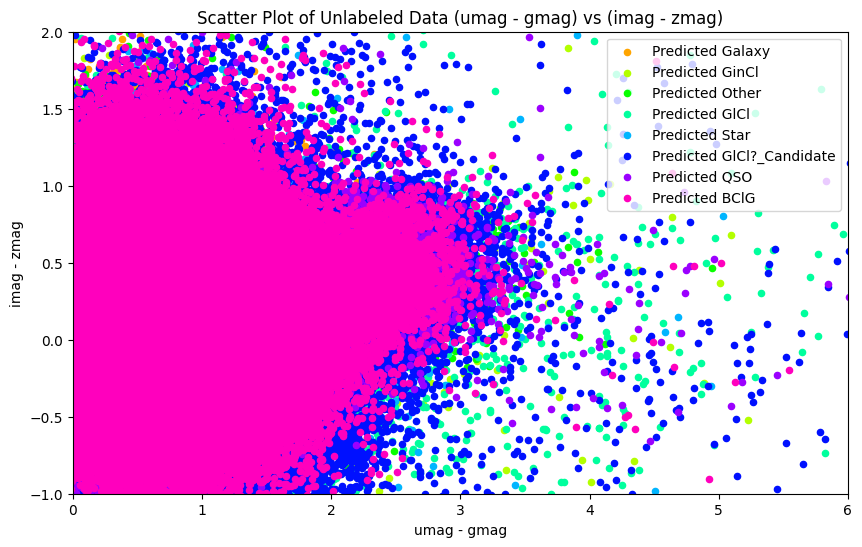

In [155]:
# Define your specific classes
classes = np.array(['Galaxy', 'GinCl',  'Other', 'GlCl', 'Star', 'GlCl?_Candidate', 'QSO', 'BClG'])
colors = sns.color_palette('hsv', len(classes))

# Plot the results
plt.figure(figsize=(10, 6))



# Highlight different predicted classes with different colors
for class_label, color in zip(classes, colors):
    class_indices = final_pred_labels == class_label
    plt.scatter(
        unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
        unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
        c=[color],  # Color for these points
        s=20,
        label=f'Predicted {class_label}'  # Label for legend
    )

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import xgboost as xgb
# import xgboost as xgb
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score


# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# # Train the classifier
# xgb_classifier.fit(X_train, y_train)


# # Apply conformal prediction using the calibration set
# mapie_clf = MapieClassifier(xgb_classifier, method="score", cv="prefit")
# mapie_clf.fit(X_train, y_train)


# # Predict with confidence intervals
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=0.99)  # 90% prediction intervals



# # Predict with prediction sets
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=0.5)  # 50% prediction sets to significantly broaden intervals

# # Check the structure of y_pis and ensure it contains prediction sets
# print(f"Structure of y_pis: {y_pis.shape}")

# # Diagnose the number of classes included in the prediction sets
# num_classes_in_pis = np.sum(y_pis, axis=1)
# print(f"Number of classes in prediction sets: {np.unique(num_classes_in_pis, return_counts=True)}")

# # Check for samples where y_pis has more than one True
# samples_with_multiple_classes = [(i, np.where(y_pis[i])[0]) for i in range(len(y_pis)) if np.sum(y_pis[i]) > 1]

# # Print the indices and prediction sets of such samples
# print("Samples with multiple classes in prediction sets:")
# for sample in samples_with_multiple_classes:
#     print(f"Sample index: {sample[0]}, Prediction set: {sample[1]}")

# # Ensure y_pis is transformed correctly for coverage calculation
# y_pis_transformed = np.array([set(np.where(y_pis[i])[0]) for i in range(len(y_pis))])

# # Create a boolean array for coverage calculation
# y_pis_boolean = np.zeros((len(y_test), len(np.unique(y_test))), dtype=bool)
# for i in range(len(y_test)):
#     y_pis_boolean[i, list(y_pis_transformed[i])] = True

# # Calculate coverage
# coverage = classification_coverage_score(y_test, y_pis_boolean)
# print(f"Coverage: {coverage:.2f}")


In [ ]:


# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Print the mapping between original labels and encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:", label_mapping)

# # Decode the labels using the dictionary
# decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
# print(decoded_labels)

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'xgboost_model.pkl'
# joblib.dump(xgb_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [ ]:
# # Get the index of the label 'GLCL'
# glcl_index = label_mapping["GLCL"]

# # Extract the row and column corresponding to 'GLCL' in the confusion matrix
# glcl_conf_matrix_row = conf_matrix[glcl_index, :]
# glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# # Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
# true_positives_glcl = glcl_conf_matrix_row[glcl_index]
# false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
# false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
# true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# # Calculate the accuracy for 'GLCL'
# accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

# print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
# print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
# print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of classes
# num_classes = conf_matrix.shape[0]

# # Initialize lists to store precision, recall, and f1 score for each label
# precisions = []
# recalls = []
# f1_scores = []



# # Calculate precision, recall, and f1 score for each class
# for i in range(num_classes):
#     tp = conf_matrix[i, i]
#     fp = np.sum(conf_matrix[:, i]) - tp
#     fn = np.sum(conf_matrix[i, :]) - tp

#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

#     precisions.append(precision)
#     recalls.append(recall)
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each class
# labels = list(label_mapping.keys())
# x = np.arange(len(labels))
# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()


############## Binary Classification with catboost

In [163]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import catboost as cb
# import numpy as np
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score
# from sklearn.model_selection import GridSearchCV
# from catboost import CatBoostClassifier



# # Decode the encoded labels back to the original labels
# y_train_decoded = label_encoder.inverse_transform(y_train)
# y_test_decoded = label_encoder.inverse_transform(y_test)
# y_calib_decoded = label_encoder.inverse_transform(y_calib)



# # Important class
# important_class = "GLCL"

# # Converting to binary labels
# y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
# y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])
# y_calib_binary = pd.Series([1 if label == important_class else 0 for label in y_calib_decoded])

# # Create a mapping for visualization
# binary_to_original_mapping = {
#     1: important_class,
#     0: 'Other'
# }
# # Define the hyperparameter grid for CatBoost
# param_grid = {
#     'iterations': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bylevel': [0.6, 0.8, 1.0]
# }

# # Initialize the CatBoost classifier
# catboost_classifier = CatBoostClassifier(random_seed=42, verbose=0)  # Ensure verbose is set to 0 for GridSearchCV

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_classifier, param_grid=param_grid, 
#                            scoring='f1', cv=5, verbose=1, n_jobs=-1)

# # Fit the GridSearchCV model
# grid_search.fit(X_train, y_train_binary)

# # Best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy Score: ", grid_search.best_score_)

# # Get the best estimator
# best_catg = grid_search.best_estimator_

# # Train the XGBoost classifier with the best estimator
# best_catg.fit(X_train, y_train_binary)

# # Get predicted probabilities
# y_pred_proba = best_catg.predict_proba(X_test)[:, 1]

# # Function to evaluate different thresholds
# def evaluate_thresholds_for_accuracy(y_test, y_pred_proba, thresholds):
#     best_threshold = 0.5
#     best_accuracy = 0.0
#     for threshold in thresholds:
#         y_pred = (y_pred_proba >= threshold).astype(int)
#         accuracy = accuracy_score(y_test, y_pred)
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_threshold = threshold
#     return best_threshold, best_accuracy

# # Define the range of thresholds to evaluate
# thresholds = [i * 0.01 for i in range(100)]

# # Find the best threshold for accuracy
# best_threshold, best_accuracy = evaluate_thresholds_for_accuracy(y_test_binary, y_pred_proba, thresholds)


# # Predict using the best threshold
# y_pred = (y_pred_proba >= best_threshold).astype(int)

# # Evaluate the model with the best threshold
# print("Best Threshold:", best_threshold)
# print("Best accuracy Score:", best_accuracy)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_binary, y_pred)
# report = classification_report(y_test_binary, y_pred)
# conf_matrix = confusion_matrix(y_test_binary, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # Decode the labels using the dictionary
# decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'catboost_model_Binary_Classification.pkl'
# joblib.dump(catboost_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [164]:
# # Initialize Mapie for conformal prediction
# mapie = MapieClassifier(estimator=best_catg, method="score", cv="prefit")

# # Fit the conformal predictor on training and calibration data combined
# mapie.fit(X_calib, y_calib_binary)

# # Get prediction intervals for probabilities
# prediction, prediction_intervals = mapie.predict(X_test, alpha=0.05)

# # Inspect the shape of prediction_intervals
# print("Prediction Intervals Shape:", prediction_intervals.shape)

# # Extract lower and upper bounds for probabilities
# lower_bounds = prediction_intervals[:, 0, 0]
# upper_bounds = prediction_intervals[:, 1, 0]

# # Calculate the error bars
# yerr_lower = y_pred_proba - lower_bounds
# yerr_upper = upper_bounds - y_pred_proba

# # Ensure yerr contains no negative values
# yerr_lower = np.maximum(0, yerr_lower)
# yerr_upper = np.maximum(0, yerr_upper)

# # Combine probabilities and intervals into a DataFrame
# results_df = pd.DataFrame({
#     'Predicted Probability': y_pred_proba,
#     'Predicted Label': y_pred,
#     'Lower Bound': lower_bounds,
#     'Upper Bound': upper_bounds,
#     'True Label': y_test_binary
# })

# # Calculate coverage
# coverage = classification_coverage_score(y_test_binary, prediction_intervals[:, :, 0])
# print("Coverage:", coverage)

# # Print and visualize the results
# print(results_df.head())

# # Sample a subset of the data
# sample_size = 50  # Adjust this to a suitable number for your data
# sampled_df = results_df.sample(n=sample_size, random_state=42)

# # Extract the sampled data
# sampled_indices = sampled_df.index
# sampled_predicted_probabilities = sampled_df['Predicted Probability'].values
# sampled_lower_bounds = sampled_df['Lower Bound'].values
# sampled_upper_bounds = sampled_df['Upper Bound'].values

# # Calculate the error bars
# sampled_yerr_lower = sampled_predicted_probabilities - sampled_lower_bounds
# sampled_yerr_upper = sampled_upper_bounds - sampled_predicted_probabilities

# # Ensure yerr contains no negative values
# sampled_yerr_lower = np.maximum(0, sampled_yerr_lower)
# sampled_yerr_upper = np.maximum(0, sampled_yerr_upper)

# # Plot the sampled data
# plt.figure(figsize=(10, 5))
# plt.errorbar(range(len(sampled_predicted_probabilities)), sampled_predicted_probabilities, yerr=[sampled_yerr_lower, sampled_yerr_upper], fmt='o')
# plt.xlabel('Sample Index')
# plt.ylabel('Predicted Probability with Intervals')
# plt.title('Sampled Predicted Probabilities with Conformal Prediction Intervals')
# plt.show()

In [186]:
# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)
y_calib_decoded = label_encoder.inverse_transform(y_calib)

In [189]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_test_decoded, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

BClG: 423
Galaxy: 2908
GinCl: 1269
GlCl: 1005
GlCl?_Candidate: 832
Other: 1316
QSO: 807
Star: 890


In [190]:


# Important class
important_class = "GlCl"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])
y_calib_binary = pd.Series([1 if label == important_class else 0 for label in y_calib_decoded])

In [191]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_test_binary, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 8445
1: 1005


<Axes: >

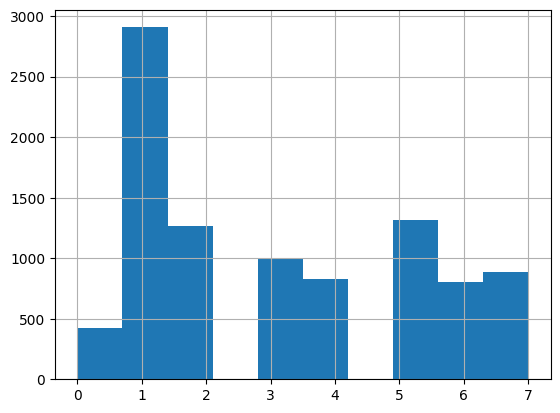

In [198]:
y_test.hist()

###########Training on xgboost with binary classification#########

In [200]:
# Check class distribution in the training set
print("Class distribution in y_train_binary:")
print(np.bincount(y_train_binary))

Class distribution in y_train_binary:
[27021  3216]


Class distribution in y_train_binary:
[27021  3216]


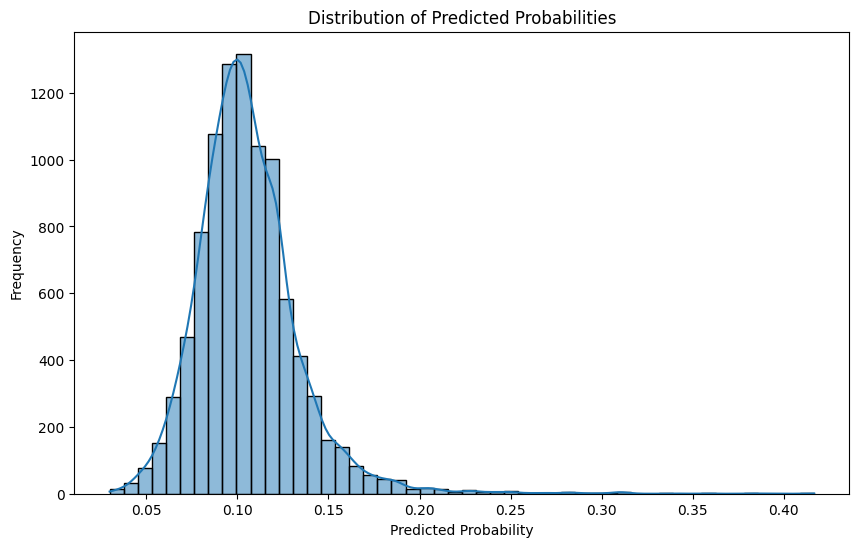

Threshold: 0.1 - F1 Score: 0.18
Threshold: 0.2 - F1 Score: 0.02
Threshold: 0.3 - F1 Score: 0.00
Threshold: 0.4 - F1 Score: 0.00
Threshold: 0.5 - F1 Score: 0.00
Threshold: 0.6 - F1 Score: 0.00
Threshold: 0.7 - F1 Score: 0.00
Threshold: 0.8 - F1 Score: 0.00
Best Threshold: 0.1 - Best F1 Score: 0.18
Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.89      0.45      0.60      8445
           1       0.11      0.55      0.18      1005

    accuracy                           0.46      9450
   macro avg       0.50      0.50      0.39      9450
weighted avg       0.81      0.46      0.55      9450



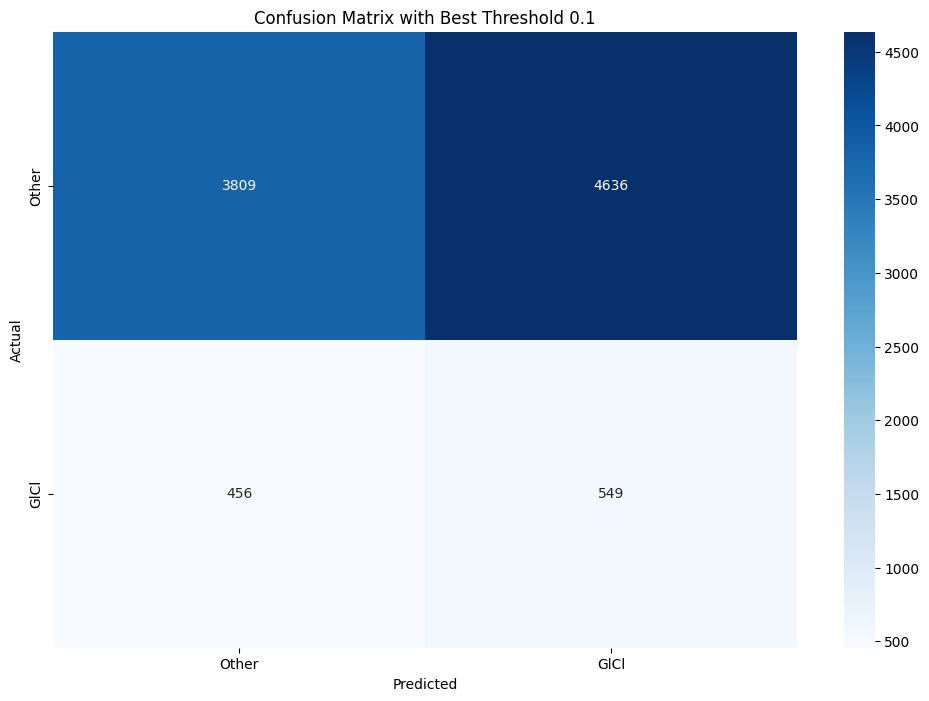

Model saved to xgboost_model_Binary_Classification.pkl


In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import numpy as np

# Initialize the XGBoost classifier with predefined hyperparameters
xgb_classifier = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the XGBoost classifier
xgb_classifier.fit(X_train, y_train_binary)

# Predict probabilities
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Check class distribution in the training set
print("Class distribution in y_train_binary:")
print(np.bincount(y_train_binary))

# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()




# Initialize variables to find the best threshold
best_threshold = 0.5
best_f1_score = 0
best_conf_matrix = None

# Adjust the threshold and evaluate
thresholds = np.arange(0.1, 0.9, 0.1)
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    current_f1_score = f1_score(y_test_binary, y_pred_adjusted)
    print(f'Threshold: {threshold:.1f} - F1 Score: {current_f1_score:.2f}')
    
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold
        best_conf_matrix = confusion_matrix(y_test_binary, y_pred_adjusted)

print(f'Best Threshold: {best_threshold:.1f} - Best F1 Score: {best_f1_score:.2f}')

# Use the best threshold for classification
y_pred = (y_pred_proba >= best_threshold).astype(int)


# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=50, kde=True)
plt.title('Distribution of Predicted ')
plt.xlabel('Predicted')
plt.ylabel('Frequency')
plt.show()

# Evaluate the classifier with the best threshold
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(report)

# Decode the labels using the dictionary
binary_to_original_mapping = {
    1: 'GlCl',
    0: 'Other'
}
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# Plot the confusion matrix for the best threshold
plt.figure(figsize=(12, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix with Best Threshold {best_threshold:.1f}')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model_Binary_Classification.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')


In [205]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_pred, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 4265
1: 5185


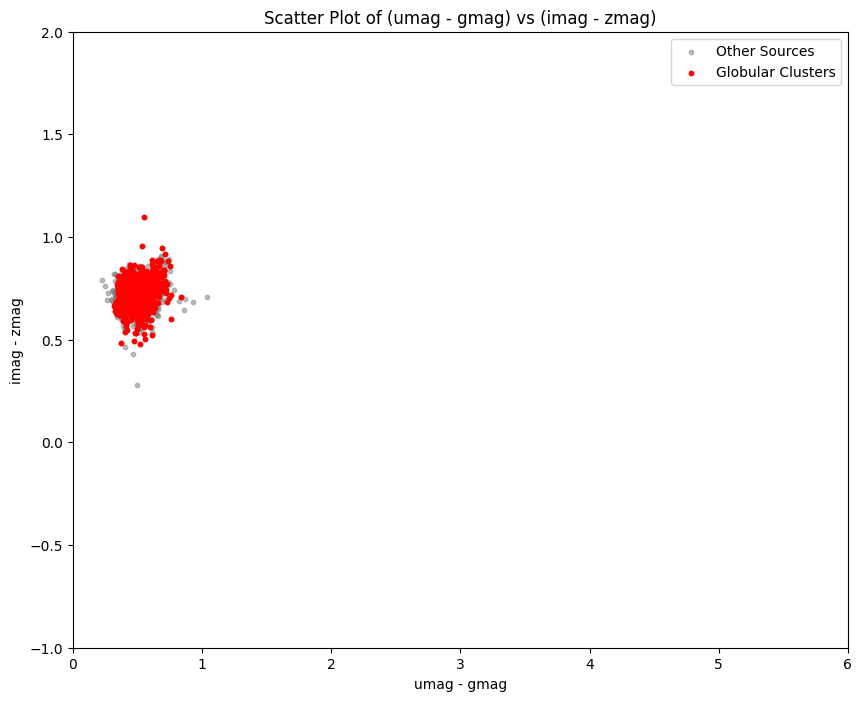

In [208]:
#  Scatter plot of (umag - gmag) vs (imag - zmag) with globular clusters highlighted
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    X_test['U_MAG_ISO_minus_G_MAG_ISO'],  # Difference between umag and gmag for x-axis
    X_test['I_MAG_ISO_minus_Z_MAG_ISO'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight globular clusters
plt.scatter(
    X_test['U_MAG_ISO_minus_G_MAG_ISO'][y_pred == 1],  # x-axis values for predicted globular clusters
    X_test['I_MAG_ISO_minus_Z_MAG_ISO'][y_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()



Unlabeled Data Analysis

In [215]:
# Make predictions on the unlabeled dataset
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)[:, 1]
unlabeled_data_pred = (unlabeled_data_proba >= 0.35).astype(int)



In [ ]:
# # Convert binary predictions to original labels using the mapping
# original_labels = np.array([binary_to_original_mapping[label] for label in unlabeled_data_pred])

# # Count occurrences of "GLCL" and "Other"
# glcl_count_un = np.sum(original_labels == "GLCL")
# other_count_un = np.sum(original_labels == "Other")
# total_count_un = len(original_labels)

# # Calculate percentage of "GLCL"
# glcl_percentage_un = (glcl_count_un / total_count_un) * 100

# print(f"Number of 'GLCL' labels in Unlabeled dataset: {glcl_count_un}")
# print(f"Number of 'Other' labels in Unlabeled dataset: {other_count_un}")
# print(f"Total number of labels in Unlabeled dataset: {total_count_un}")

# print(f"Percentage of 'GLCL' labels in Unlabeled dataset: {glcl_percentage_un:.2f}%")

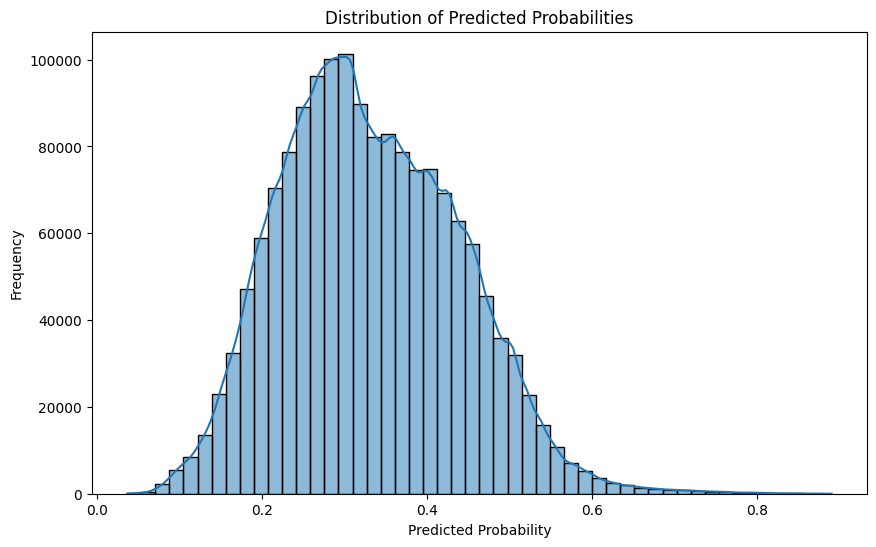

In [216]:
# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(unlabeled_data_proba, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

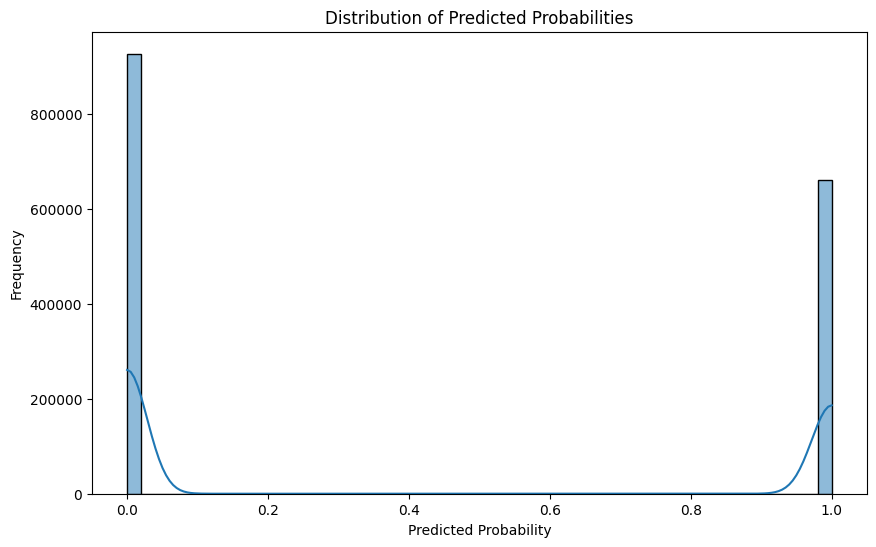

In [217]:
# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(unlabeled_data_pred, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


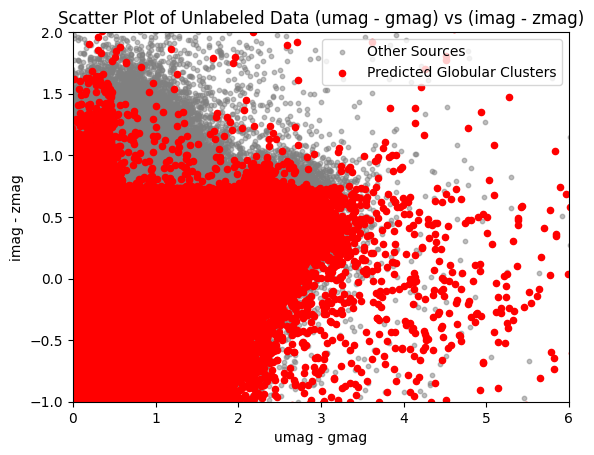

In [218]:
# Plot other sources
plt.scatter(
    unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'],  # Difference between umag and gmag for x-axis
    unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight predicted globular clusters
plt.scatter(
    unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'][unlabeled_data_pred == 1],  # x-axis values for predicted globular clusters
    unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'][unlabeled_data_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=20,
    label='Predicted Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler


# # Select the relevant columns for dimensionality reduction
# # features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', ]
# features = ['umag_minus_gmag', 'umag_minus_rmag', 'umag_minus_imag',
#        'umag_minus_zmag', 'gmag_minus_rmag', 'gmag_minus_imag',
#        'gmag_minus_zmag', 'rmag_minus_imag', 'rmag_minus_zmag',
#        'imag_minus_zmag']

# unlabeled_data_features = unlabeled_data[features]

# # Standardize the data
# tsne_scaler = StandardScaler()
# unlabeled_data_scaled = tsne_scaler.fit_transform(unlabeled_data_features)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the t-SNE results
# tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'],  index=unlabeled_data.index)

# # Apply UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# umap_results = umap_model.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the UMAP results
# umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'],  index=unlabeled_data.index)


# # Visualize t-SNE results
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(tsne_df['TSNE1'][unlabeled_data_pred == 1], tsne_df['TSNE2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2')
# plt.legend()
# plt.title('t-SNE Scatter Plot of Unlabeled Data')
# plt.show()

# # Visualize UMAP results
# plt.figure(figsize=(10, 8))
# plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(umap_df['UMAP1'][unlabeled_data_pred == 1], umap_df['UMAP2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.title('UMAP Scatter Plot of Unlabeled Data')
# plt.show()


Countdown the targets predicted on unlabeled data

In [ ]:
# # Get unique values of the predicted labels
# unique_predictions = pd.Series(unlabeled_predictions_decoded).unique()
# print(f'Unique predicted labels: {unique_predictions}')

########### Training on Random Forest
############
############
###########
###########

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Print the mapping between original labels and encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:", label_mapping)

# # Decode the labels using the dictionary
# decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
# print(decoded_labels)

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()


# # Feature importance
# feature_importances = rf_classifier.feature_importances_
# features = X_train.columns

# # Plot feature importances
# plt.figure(figsize=(12, 8))
# sns.barplot(x=feature_importances, y=features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Feature Importances in Random Forest Classifier')
# plt.show()

# # Save the trained model to a file
# model_filename = 'random_forest_model.pkl'
# joblib.dump(rf_classifier, model_filename)
# print(f'Model saved to {model_filename}')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of classes
# num_classes = conf_matrix.shape[0]

# # Initialize lists to store precision, recall, and f1 score for each label
# precisions = []
# recalls = []
# f1_scores = []



# # Calculate precision, recall, and f1 score for each class
# for i in range(num_classes):
#     tp = conf_matrix[i, i]
#     fp = np.sum(conf_matrix[:, i]) - tp
#     fn = np.sum(conf_matrix[i, :]) - tp

#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

#     precisions.append(precision)
#     recalls.append(recall)
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each class
# labels = list(label_mapping.keys())
# x = np.arange(len(labels))
# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()

######## Training on random Forest by Binarization #######

In [ ]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib

# # Decode the encoded labels back to the original labels
# y_train_decoded = label_encoder.inverse_transform(y_train)
# y_test_decoded = label_encoder.inverse_transform(y_test)

# # Important class
# important_class = "GLCL"

# # Converting to binary labels
# y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
# y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# # Create a mapping for visualization
# binary_to_original_mapping = {
#     1: important_class,
#     0: 'Other'
# }

# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train_binary)

# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_binary, y_pred)
# report = classification_report(y_test_binary, y_pred)
# conf_matrix = confusion_matrix(y_test_binary, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Decode the labels using the dictionary
# decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'RandomForest_model_Binary_Classification.pkl'
# joblib.dump(rf_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize lists to store precision, recall, accuracy, and F1 score for each label
# precisions = []
# recalls = []
# f1_scores = []

# print(binary_to_original_mapping.items())

# # Calculate precision, recall, accuracy, and F1 score for each label
# for index, label in binary_to_original_mapping.items():  # Swap label and index
#     print(f"Processing index: {index}, label: {label}")
    
#     if index == 1:
#         print("Index is 1")
#         # True Positives (TP): Diagonal element for the current label
#         tp = conf_matrix[1, 1]

#         # False Positives (FP): Sum of the column for the current label excluding the diagonal element
#         fp = conf_matrix[0, 1]

#         # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
#         fn = conf_matrix[1, 0]

#         # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
#         tn = conf_matrix[0, 0]
#     elif index == 0:
#         print("Index is 0")
#         # True Positives (TP): Diagonal element for the current label
#         tp = conf_matrix[0, 0]

#         # False Positives (FP): Sum of the column for the current label excluding the diagonal element
#         fp = conf_matrix[1, 0]

#         # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
#         fn = conf_matrix[0, 1]

#         # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
#         tn = conf_matrix[1, 1]
#     else:
#         assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
#         print("Index is neither 0 nor 1, skipping this index")
#         continue  # Skip labels not covered in the binary mapping

#     # Calculate Precision
#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     precisions.append(precision)

#     # Calculate Recall
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     recalls.append(recall)

#     # Calculate F1 Score
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each label
# labels = list(binary_to_original_mapping.values())
# x = np.arange(len(labels))

# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()